Step 1: Data Acquisition

Here we set up the templates for the information we want to retrieve from the API. We also create a subset to specify that we want to pull articles having to do with dinosaur Wikipedia articles.

In [1]:
# These are standard python modules
import json, time, urllib.parse
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': 'mh808@uw.edu, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

ARTICLE_TITLES = pd.read_csv("../raw_data/dino_clean.csv")["name"]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022100100"    # this is likely the wrong end date
}

Function that gets pageviews per article and returns json response

In [2]:
def request_pageviews_per_article(article_title = None, 
                                  access = "desktop",
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    request_template['access'] = access
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response['items']


Acquiring page view data from mobile web and mobile app access and combining them into one JSON object with all mobile views


In [4]:
mobile_web_dict = {} #only web
mobile_app_dict = {} #only app
mobile_dict = {} #web and app combined

for title in ARTICLE_TITLES:
  mobile_web_dict[title] = request_pageviews_per_article(title, "mobile-web")
  mobile_app_dict[title] = request_pageviews_per_article(title, "mobile-app")
  mobile_combined = []
  for i, j in zip(mobile_web_dict[title], mobile_app_dict[title]):
    if i["timestamp"] == j["timestamp"]:
      update = {**i, 'views': i['views']+j['views']}
      del update['access']
      mobile_combined.append(update)
  mobile_dict[title] = mobile_combined

Retrieving desktop page view data

In [5]:
desktop_dict = {}
for title in ARTICLE_TITLES:
  desktop_dict[title] = request_pageviews_per_article(title, "desktop")

Retrieving cumulative total of desktop and mobile page view data with a running total per article (i.e. views from July 2015 are added to views in August 2015 and future months)

In [ ]:
cumu_dict = {}
cumu = []
update = {}
total = 0
for title in ARTICLE_TITLES:
  cumu = []
  for i, j in zip(mobile_dict[title], desktop_dict[title]):
    if len(update)==0:
      update = {**i, 'views': i['views']+j['views']}
      total = i['views']+j['views']
      cumu.append(update)
    else:
      update = {**i, 'views': total+i['views']+j['views']}
      total += i['views']+j['views']
      cumu.append(update)

  update = {}
  total = 0
  cumu_dict[title] = cumu


Writing to JSON output files

In [33]:
start = "201507"
end = "202210"

with open("dino_monthly_mobile_" + start + "-" + end + ".json", "w") as f:
    json.dump(mobile_dict, f)

with open("dino_monthly_desktop_" + start + "-" + end + ".json", "w") as f:
    json.dump(desktop_dict, f)
    
with open("dino_monthly_cumulative_" + start + "-" + end + ".json", "w") as f:
    json.dump(cumu_dict, f)

Converting JSON files to dataframes for easier data manipulation

In [6]:
import pandas as pd


df_mobile = pd.DataFrame(columns =  pd.date_range("2015-07-01", "2022-10-01", freq="MS").strftime("%Y%m0100").tolist())

for title in list(mobile_dict.keys()): 
  x = pd.DataFrame.from_records(mobile_dict[title], columns=["timestamp", "views"]).set_index("timestamp").T.rename({"views": title})
  df_mobile = df_mobile.append(x)

df_desktop = pd.DataFrame(columns =  pd.date_range("2015-07-01", "2022-10-01", freq="MS").strftime("%Y%m0100").tolist())

for title in list(desktop_dict.keys()):
  x = pd.DataFrame.from_records(desktop_dict[title], columns=["timestamp", "views"]).set_index("timestamp").T.rename({"views": title})
  df_desktop = df_desktop.append(x)


Step 2: Data Analysis


We are plotting the maximum average and minimum average over a time series for mobile and desktop access page views.

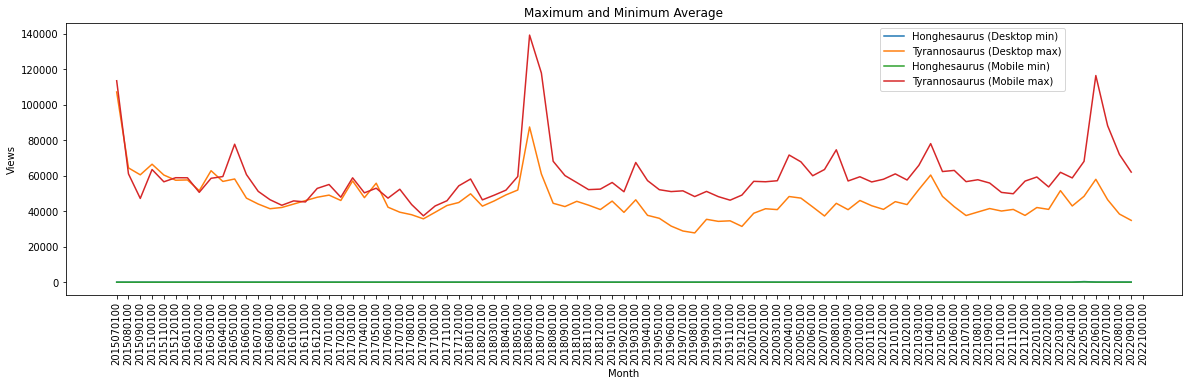

In [9]:
import matplotlib.pyplot as plt
import matplotlib.axes

desk_means = df_desktop.mean(axis = 1).sort_values()
mob_means = df_mobile.mean(axis = 1).sort_values()
df = df_desktop.loc[[desk_means.index[0], desk_means.index[-1]]].append(
    df_mobile.loc[[mob_means.index[0], mob_means.index[-1]]]
)

df.index = [desk_means.index[0] + " (Desktop min)",
    desk_means.index[-1] + " (Desktop max)",
    mob_means.index[0] + " (Mobile min)",
    mob_means.index[-1] + " (Mobile max)"]

plt.rcParams["figure.figsize"] = (20,5)
plt.title("Maximum and Minimum Average")
plt.ylabel("Views")
plt.xlabel("Month")
plt.xticks(rotation='vertical')

for name, row in df.iterrows():
  plt.plot(row, label = name)
plt.legend(df.index, bbox_to_anchor = [0.9, 1])



This graph shows the top 10 articles that are viewed by mobile and desktop respectively. 

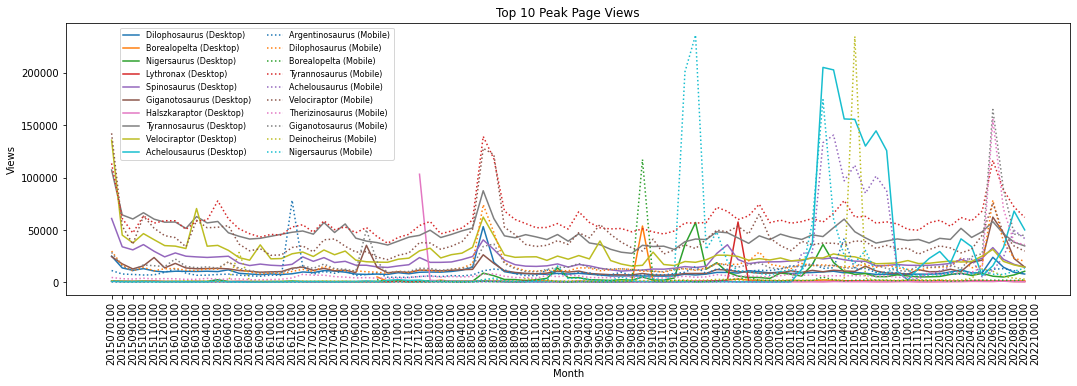

In [40]:
desk_max = df_desktop.max(axis=1).sort_values().index[-10:]
mobile_max = df_mobile.max(axis=1).sort_values().index[-10:]

x1 = df_desktop.loc[desk_max]
x1.index = [i + " (Desktop)" for i in x1.index.tolist()]
x2 = df_mobile.loc[mobile_max]
x2.index = [i + " (Mobile)" for i in x2.index.tolist()]

df2 = x1.append(x2)

plt.rcParams["figure.figsize"] = (18,5)
plt.title("Top 10 Peak Page Views")
plt.ylabel("Views")
plt.xlabel("Month")
plt.xticks(rotation='vertical')

for name, row in df2.iterrows():
  plt.plot(row, ":" if "Mobile" in name else "-", label = name)
plt.legend(df2.index, bbox_to_anchor = [0.05, 0.48], ncol = 2, fontsize = 8)


This graph shows pages that have the fewest months of data.

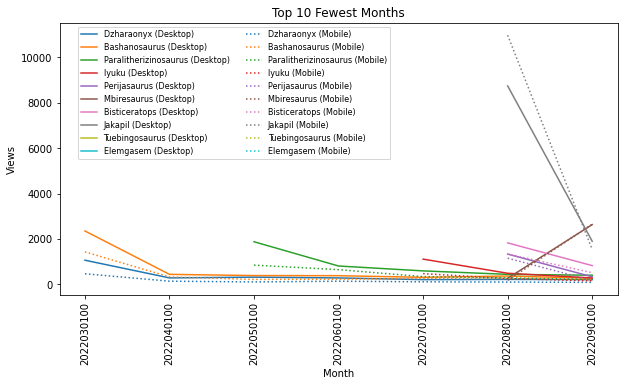

In [47]:
desk_min = df_desktop.isna().sum(axis = 1).sort_values().index[-10:]
mobile_min = df_mobile.isna().sum(axis = 1).sort_values().index[-10:]

x1 = df_desktop.loc[desk_min]
x1.index = [i + " (Desktop)" for i in x1.index.tolist()]
x2 = df_mobile.loc[mobile_min]
x2.index = [i + " (Mobile)" for i in x2.index.tolist()]

df3 = x1.append(x2)

plt.rcParams["figure.figsize"] = (10,5)
plt.title("Top 10 Fewest Months")
plt.ylabel("Views")
plt.xlabel("Month")
plt.xticks(rotation='vertical')

for name, row in df3.iterrows():
  plt.plot(row, ":" if "Mobile" in name else "-",label = name)
plt.legend(df3.index, bbox_to_anchor = [0.6, 1], ncol = 2, fontsize = 8)
